In [1]:
# Import Relevant Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image

# Neural network libraries

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, losses, metrics, Input, regularizers
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
np.random.seed(42)

## Ideas
1. FSM with one layer
    - Show with original data & augmented data
2. Next model: 
    - add two extra hidden layers
    - change to relu
    - try (L2) regularization & dropout
3. FSM CNN (with convolution)
4. Next CNN model, more convolutional layers and dropout
    - (assuming we're overfitting to train data) try regularization & dropout
    - futz with batch size and epochs


### Additional ideas
- AAB: try multiclass problem to identify viral, bacteria, or none

In [2]:
# # Running in Google Colab
# from google.colab import drive

# drive.mount('/content/gdrive')
# root_path = 'gdrive/My Drive/Colab Notebooks/Pneumonia/' 

In [3]:
# Running locally
root_path = '../'

In [4]:
train_path = root_path + 'data/chest_xray/train/'
test_path = root_path + 'data/chest_xray/test/'

## Generate augmented data to force model to be more generalizable

In [5]:
train_idg = ImageDataGenerator(rescale=1/255,
                               validation_split = 0.20,
                               rotation_range=40, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
                                   

train_set_aug = train_idg.flow_from_directory(train_path, target_size=(128, 128), 
                                         color_mode='grayscale', class_mode='binary', subset='training')

validation_set_aug = train_idg.flow_from_directory(train_path, target_size=(128, 128), 
                                         color_mode='grayscale', class_mode='binary', subset='validation')



Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [12]:
# Don't augment the test set
idg = ImageDataGenerator(rescale=1/255, validation_split=0.20)
test_set = idg.flow_from_directory(test_path, 
                                   target_size=(128,128), 
                                   color_mode='grayscale', 
                                   class_mode='binary', 
                                   shuffle=False)

Found 624 images belonging to 2 classes.


In [6]:
classes = pd.DataFrame(train_set_aug.classes)
class_dict = {0:'Normal', 1:'Pneumonia'}
classes[0] = classes[0].map(class_dict)
classes.value_counts()

Pneumonia    3100
Normal       1073
dtype: int64

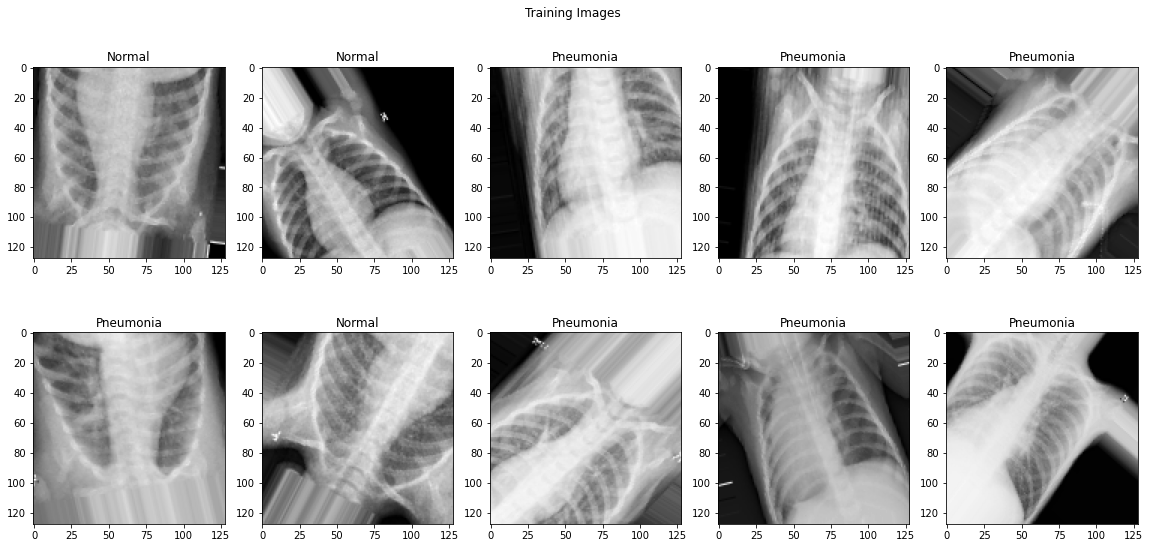

In [7]:
# # Visualize
train_images = train_set_aug.next()
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

#train_images

for i in range(10):
    # Load image into numpy array and re-scale
    img = np.array(train_images[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.set_title(class_dict[train_images[1][i]])
    ax.imshow(img, cmap ='gray')
fig.suptitle('Training Images')
plt.tight_layout()
plt.show()

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

## CNN

In [8]:
deep_cnn = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

deep_cnn.compile(optimizer='SGD',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])

deep_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1843232   
_________________________________________________________________
dense_1 (Dense)              (None, 12)                3

In [9]:
deep_cnn_results = deep_cnn.fit(train_set_aug, 
                                epochs=100, 
                                batch_size=None, 
                                validation_data=validation_set_aug)

Epoch 1/100
131/131 [==============================] - 91s 692ms/step - loss: 0.6734 - accuracy: 0.7417 - recall: 0.9968 - precision: 0.7431 - true_positives: 3090.0000 - true_negatives: 5.0000 - false_positives: 1068.0000 - false_negatives: 10.0000 - auc: 0.5020 - val_loss: 0.6565 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.5898
Epoch 2/100
131/131 [==============================] - 89s 681ms/step - loss: 0.6622 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.5238 - val_loss: 0.6502 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.

131/131 [==============================] - 84s 644ms/step - loss: 0.5154 - accuracy: 0.7997 - recall: 0.9226 - precision: 0.8275 - true_positives: 2860.0000 - true_negatives: 477.0000 - false_positives: 596.0000 - false_negatives: 240.0000 - auc: 0.8309 - val_loss: 0.5290 - val_accuracy: 0.7824 - val_recall: 0.9110 - val_precision: 0.8171 - val_true_positives: 706.0000 - val_true_negatives: 110.0000 - val_false_positives: 158.0000 - val_false_negatives: 69.0000 - val_auc: 0.8175
Epoch 18/100
131/131 [==============================] - 83s 633ms/step - loss: 0.5030 - accuracy: 0.8140 - recall: 0.9203 - precision: 0.8436 - true_positives: 2853.0000 - true_negatives: 544.0000 - false_positives: 529.0000 - false_negatives: 247.0000 - auc: 0.8421 - val_loss: 0.5167 - val_accuracy: 0.7967 - val_recall: 0.9355 - val_precision: 0.8174 - val_true_positives: 725.0000 - val_true_negatives: 106.0000 - val_false_positives: 162.0000 - val_false_negatives: 50.0000 - val_auc: 0.8322
Epoch 19/100
131/13

131/131 [==============================] - 79s 605ms/step - loss: 0.3758 - accuracy: 0.8677 - recall: 0.9294 - precision: 0.8964 - true_positives: 2881.0000 - true_negatives: 740.0000 - false_positives: 333.0000 - false_negatives: 219.0000 - auc: 0.9282 - val_loss: 0.4160 - val_accuracy: 0.8514 - val_recall: 0.9135 - val_precision: 0.8894 - val_true_positives: 708.0000 - val_true_negatives: 180.0000 - val_false_positives: 88.0000 - val_false_negatives: 67.0000 - val_auc: 0.9048
Epoch 34/100
131/131 [==============================] - 80s 607ms/step - loss: 0.3643 - accuracy: 0.8785 - recall: 0.9290 - precision: 0.9094 - true_positives: 2880.0000 - true_negatives: 786.0000 - false_positives: 287.0000 - false_negatives: 220.0000 - auc: 0.9351 - val_loss: 0.3950 - val_accuracy: 0.8552 - val_recall: 0.8994 - val_precision: 0.9052 - val_true_positives: 697.0000 - val_true_negatives: 195.0000 - val_false_positives: 73.0000 - val_false_negatives: 78.0000 - val_auc: 0.9192
Epoch 35/100
131/131 

Epoch 50/100
131/131 [==============================] - 72s 549ms/step - loss: 0.3139 - accuracy: 0.9017 - recall: 0.9429 - precision: 0.9262 - true_positives: 2923.0000 - true_negatives: 840.0000 - false_positives: 233.0000 - false_negatives: 177.0000 - auc: 0.9543 - val_loss: 0.3353 - val_accuracy: 0.8897 - val_recall: 0.9574 - val_precision: 0.9005 - val_true_positives: 742.0000 - val_true_negatives: 186.0000 - val_false_positives: 82.0000 - val_false_negatives: 33.0000 - val_auc: 0.9482
Epoch 51/100
131/131 [==============================] - 72s 550ms/step - loss: 0.3043 - accuracy: 0.9051 - recall: 0.9465 - precision: 0.9273 - true_positives: 2934.0000 - true_negatives: 843.0000 - false_positives: 230.0000 - false_negatives: 166.0000 - auc: 0.9587 - val_loss: 0.3578 - val_accuracy: 0.8658 - val_recall: 0.9523 - val_precision: 0.8775 - val_true_positives: 738.0000 - val_true_negatives: 165.0000 - val_false_positives: 103.0000 - val_false_negatives: 37.0000 - val_auc: 0.9430
Epoch 5

131/131 [==============================] - 80s 613ms/step - loss: 0.2819 - accuracy: 0.9166 - recall: 0.9490 - precision: 0.9393 - true_positives: 2942.0000 - true_negatives: 883.0000 - false_positives: 190.0000 - false_negatives: 158.0000 - auc: 0.9648 - val_loss: 0.3192 - val_accuracy: 0.9003 - val_recall: 0.9123 - val_precision: 0.9515 - val_true_positives: 707.0000 - val_true_negatives: 232.0000 - val_false_positives: 36.0000 - val_false_negatives: 68.0000 - val_auc: 0.9556
Epoch 67/100
131/131 [==============================] - 77s 590ms/step - loss: 0.2905 - accuracy: 0.9113 - recall: 0.9465 - precision: 0.9350 - true_positives: 2934.0000 - true_negatives: 869.0000 - false_positives: 204.0000 - false_negatives: 166.0000 - auc: 0.9606 - val_loss: 0.3093 - val_accuracy: 0.8859 - val_recall: 0.9548 - val_precision: 0.8981 - val_true_positives: 740.0000 - val_true_negatives: 184.0000 - val_false_positives: 84.0000 - val_false_negatives: 35.0000 - val_auc: 0.9586
Epoch 68/100
131/131 

Epoch 83/100
131/131 [==============================] - 70s 536ms/step - loss: 0.2655 - accuracy: 0.9224 - recall: 0.9500 - precision: 0.9457 - true_positives: 2945.0000 - true_negatives: 904.0000 - false_positives: 169.0000 - false_negatives: 155.0000 - auc: 0.9683 - val_loss: 0.2921 - val_accuracy: 0.9003 - val_recall: 0.9316 - val_precision: 0.9340 - val_true_positives: 722.0000 - val_true_negatives: 217.0000 - val_false_positives: 51.0000 - val_false_negatives: 53.0000 - val_auc: 0.9606
Epoch 84/100
131/131 [==============================] - 72s 553ms/step - loss: 0.2611 - accuracy: 0.9233 - recall: 0.9516 - precision: 0.9455 - true_positives: 2950.0000 - true_negatives: 903.0000 - false_positives: 170.0000 - false_negatives: 150.0000 - auc: 0.9695 - val_loss: 0.2882 - val_accuracy: 0.9003 - val_recall: 0.9432 - val_precision: 0.9241 - val_true_positives: 731.0000 - val_true_negatives: 208.0000 - val_false_positives: 60.0000 - val_false_negatives: 44.0000 - val_auc: 0.9627
Epoch 85

131/131 [==============================] - 67s 510ms/step - loss: 0.2531 - accuracy: 0.9267 - recall: 0.9519 - precision: 0.9495 - true_positives: 2951.0000 - true_negatives: 916.0000 - false_positives: 157.0000 - false_negatives: 149.0000 - auc: 0.9708 - val_loss: 0.3301 - val_accuracy: 0.8734 - val_recall: 0.8697 - val_precision: 0.9560 - val_true_positives: 674.0000 - val_true_negatives: 237.0000 - val_false_positives: 31.0000 - val_false_negatives: 101.0000 - val_auc: 0.9582
Epoch 100/100
131/131 [==============================] - 69s 530ms/step - loss: 0.2510 - accuracy: 0.9286 - recall: 0.9571 - precision: 0.9473 - true_positives: 2967.0000 - true_negatives: 908.0000 - false_positives: 165.0000 - false_negatives: 133.0000 - auc: 0.9719 - val_loss: 0.2860 - val_accuracy: 0.9108 - val_recall: 0.9123 - val_precision: 0.9658 - val_true_positives: 707.0000 - val_true_negatives: 243.0000 - val_false_positives: 25.0000 - val_false_negatives: 68.0000 - val_auc: 0.9676


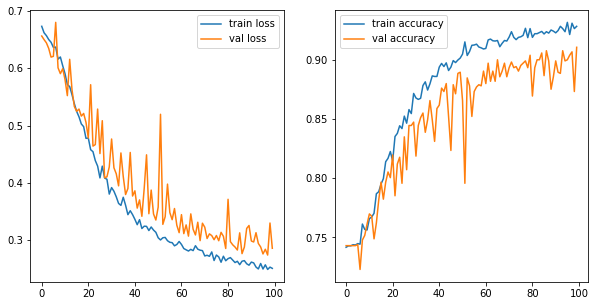

In [16]:
sigmoid_loss = deep_cnn_results.history['loss']
sigmoid_accuracy = deep_cnn_results.history['accuracy']
val_loss = deep_cnn_results.history['val_loss']
val_accuracy = deep_cnn_results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=deep_cnn_results.epoch, y=sigmoid_loss, ax=ax1, label='train loss')
sns.lineplot(x=deep_cnn_results.epoch, y=sigmoid_accuracy, ax=ax2, label='train accuracy')
sns.lineplot(x=deep_cnn_results.epoch, y=val_loss, ax=ax1, label='val loss')
sns.lineplot(x=deep_cnn_results.epoch, y=val_accuracy, ax=ax2, label='val accuracy')
ax1.legend();
plt.savefig('../images/training_performance_deep_cnn.jpg', transparent = False, bbox_inches="tight")

In [13]:
deep_cnn.evaluate(test_set)

20/20 [==============================] - 4s 212ms/step - loss: 0.3685 - accuracy: 0.8734 - recall: 0.8821 - precision: 0.9125 - true_positives: 344.0000 - true_negatives: 201.0000 - false_positives: 33.0000 - false_negatives: 46.0000 - auc: 0.9427


[0.36847665905952454,
 0.8733974099159241,
 0.8820512890815735,
 0.912466824054718,
 344.0,
 201.0,
 33.0,
 46.0,
 0.9426583051681519]

In [15]:
output_path = root_path + 'data/deep_cnn.h5'
deep_cnn.save(output_path)

# Appears that you also need to save history separately (untested)
# convert results.history to csv and save it out
hist_df = pd.DataFrame(deep_cnn_results.history)
hist_df.to_csv(output_path.replace(".h5", ".csv"), index=False)


# # https://stackoverflow.com/questions/47843265/how-can-i-get-a-keras-models-history-after-loading-it-from-a-file-in-python
# from keras.callbacks import CSVLogger
# csv_logger = CSVLogger('training.log', separator=',', append=False)
# model.fit(X_train, Y_train, callbacks=[csv_logger])

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***